In [177]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [215]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import numpy as np
!pip install scikit-learn

# Data generation

In [165]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

samples =20
nvars = 200
sigma = 0.05



def generate_data(samples,nvars,sigma,beta_sigma = 1e-2,ntest = 300):
    X = np.random.randn(samples,nvars)
    coefs = np.zeros(nvars)+beta_sigma*np.random.randn(nvars)
    coefs[0] = 0.9
    coefs[1] = 2.1
    beta_sigma = beta_sigma
    sigma = sigma
    coefs = np.zeros(nvars)+beta_sigma*np.random.randn(nvars)
    coefs[0] = 0.9
    coefs[1] = 2.1

    noise = sigma*np.random.randn(samples)
    Ydata = np.sum(coefs*X,axis = 1)+noise
    Ydata = Ydata[:,None]
    Xtest = np.random.randn(ntest,nvars)
    Ytest = np.sum(coefs*Xtest,axis = 1)+ sigma*np.random.randn(ntest)
    Ydata = Ydata.reshape(-1)
    Ytest = Ytest.reshape(-1)
    return X,Ydata,Xtest,Ytest

X,Ydata,Xtest,Ytest = generate_data(samples,nvars,sigma)

$$ Y=X\beta^{T}+\epsilon$$
$$\epsilon \sim \mathcal{N}(0,5e-2)$$
$$ N_{s} \quad coefficients \quad \beta_{small}\sim \mathcal{N}(0,1e-2)$$
$$ N_{r} \quad coefficients \quad  \beta_{relevant}\sim \mathcal{N}(0,1),\beta_{1} = 0.9, \beta_{2} = 2.1$$
$$ N_{r} = 2 <<N_{s} = 200$$
$$ n_{samples} = 20<<p_{predictors} = 202$$

# Lasso Cv to compare 

/conda/opt/envs/pymc_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.470e-02, tolerance: 7.495e-03
  model = cd_fast.enet_coordinate_descent(
/conda/opt/envs/pymc_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.054e-02, tolerance: 8.568e-03
  model = cd_fast.enet_coordinate_descent(


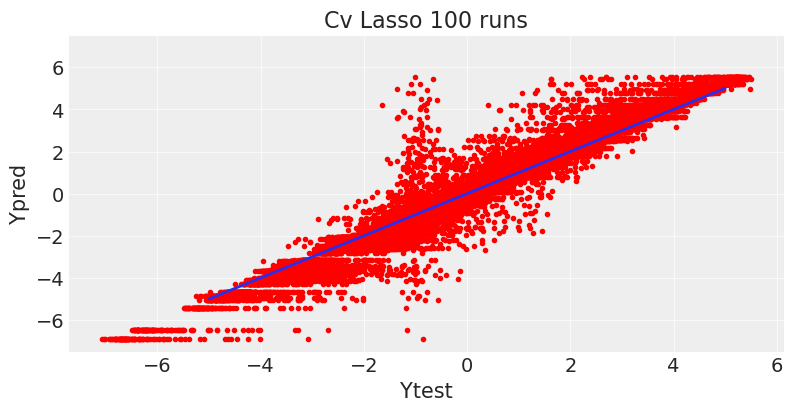

In [180]:
from sklearn.linear_model import Lasso,LassoCV,LinearRegression

nfits = 100
X_,Ydata_,Xtest,Ytest = generate_data(samples,nvars,sigma)
coefs = []
alfas = []
plt.figure(figsize = (15,4))
plt.subplot(121)
for i in range(nfits):
    ls = LassoCV()
    X_,Ydata_,_,_ = generate_data(samples,nvars,sigma)

    ls.fit(X_,Ydata_)
    Ypred = ls.predict(Xtest)
    coefs.append(ls.coef_)
    plt.plot(Ypred,Ytest,'.',color = "red")
    alfas.append(ls.alpha_)
alfas = np.array(alfas)
         
plt.plot([-5,5],[-5,5])
plt.ylim(-7.5,7.5)
plt.title("Cv Lasso 100 runs")
plt.ylabel("Ypred")
plt.xlabel("Ytest")
coefs = np.array(coefs)



# Inference with Laplace Prior

In [189]:
model = pm.Model()
beta_sigma = 1e-2
with model:

    betaprior = pm.Uniform('betaprior',0.007,0.02)
    beta = pm.Laplace('beta',0,betaprior, shape = (nvars))

    ymu = pm.math.dot(X,beta)

    ysigma = pm.ChiSquared("chi",samples-1)
    ysigma =ysigma*(nvars*beta_sigma**2+sigma**2)/(samples-1)
    ysigma = pm.Deterministic("sigma",np.sqrt(ysigma))
    
    y = pm.Normal("Y",ymu,ysigma,observed = Ydata)
    idata = pm.sample(1000, tune = 500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betaprior, beta, chi]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 25 seconds.


## Plot results

Text(0.5, 1.0, 'strong variables avg coefficients')

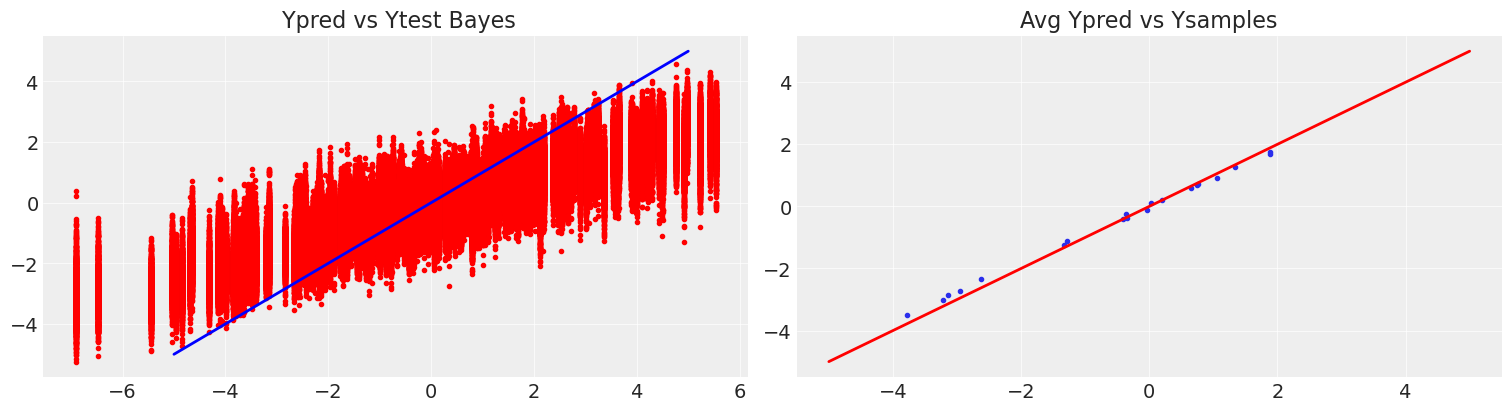

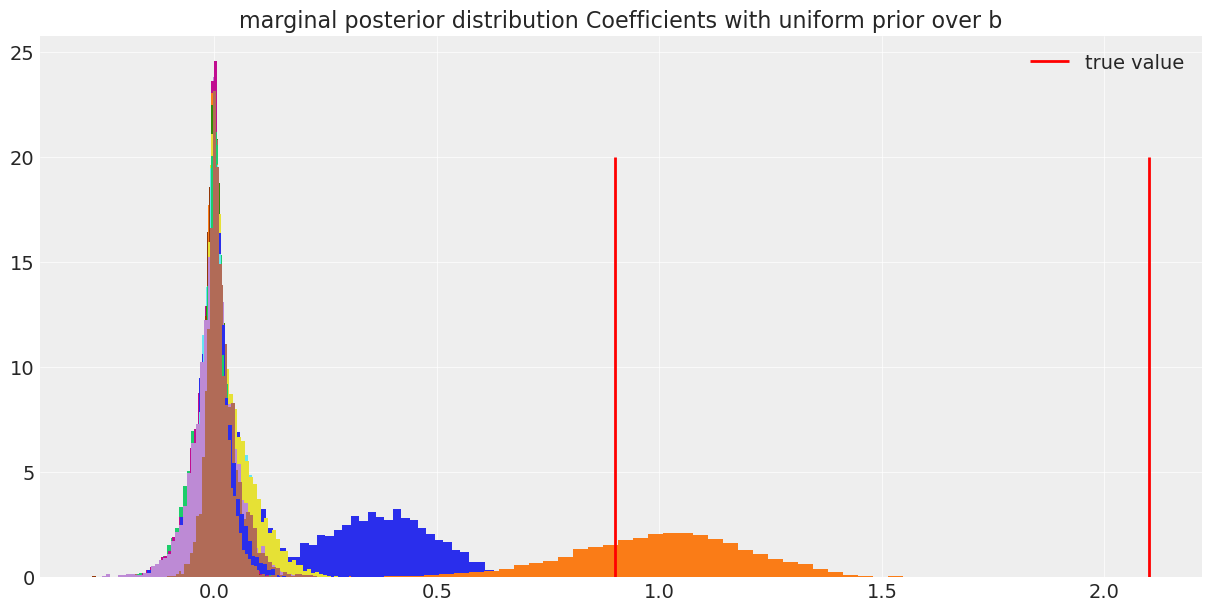

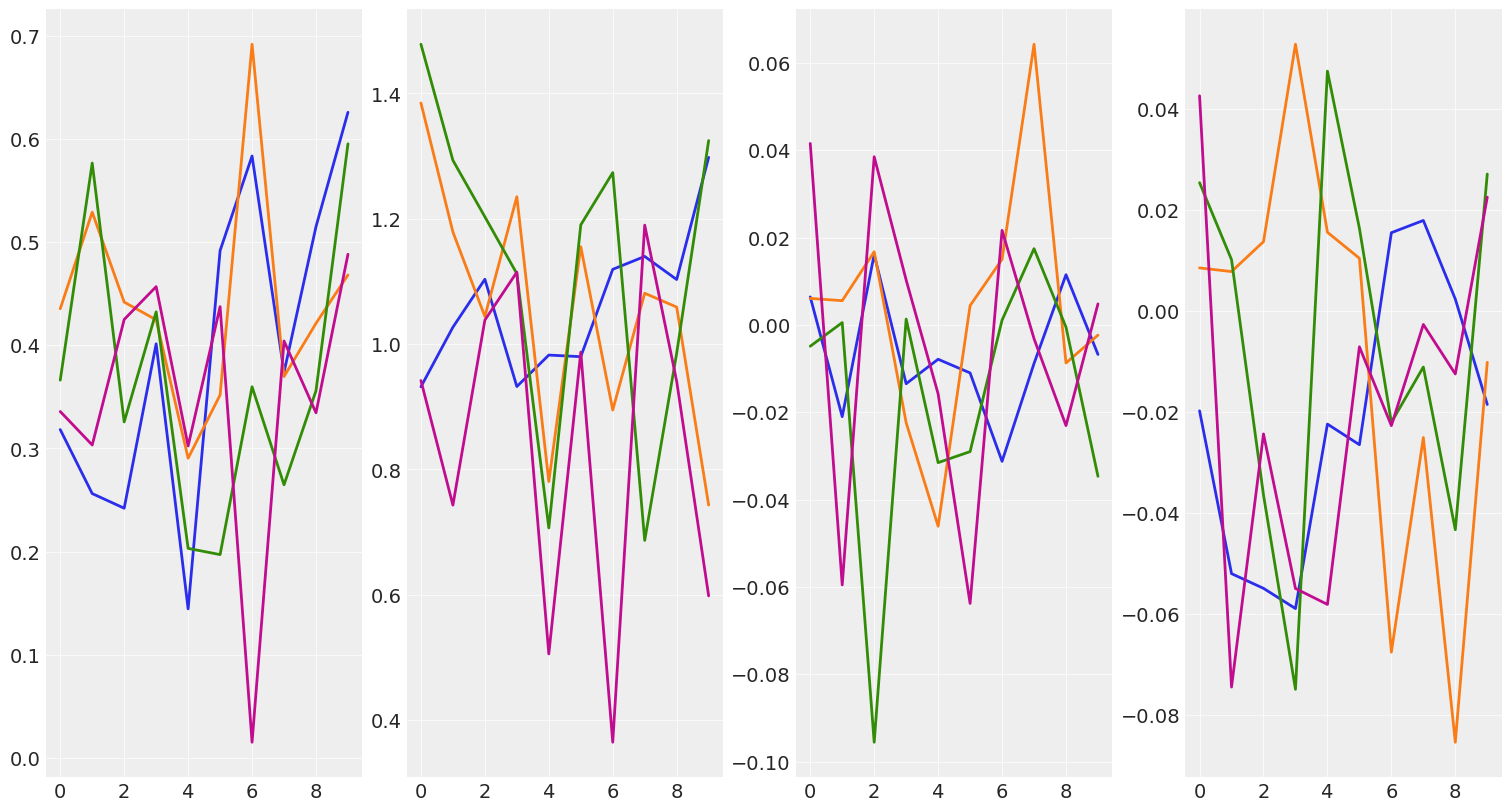

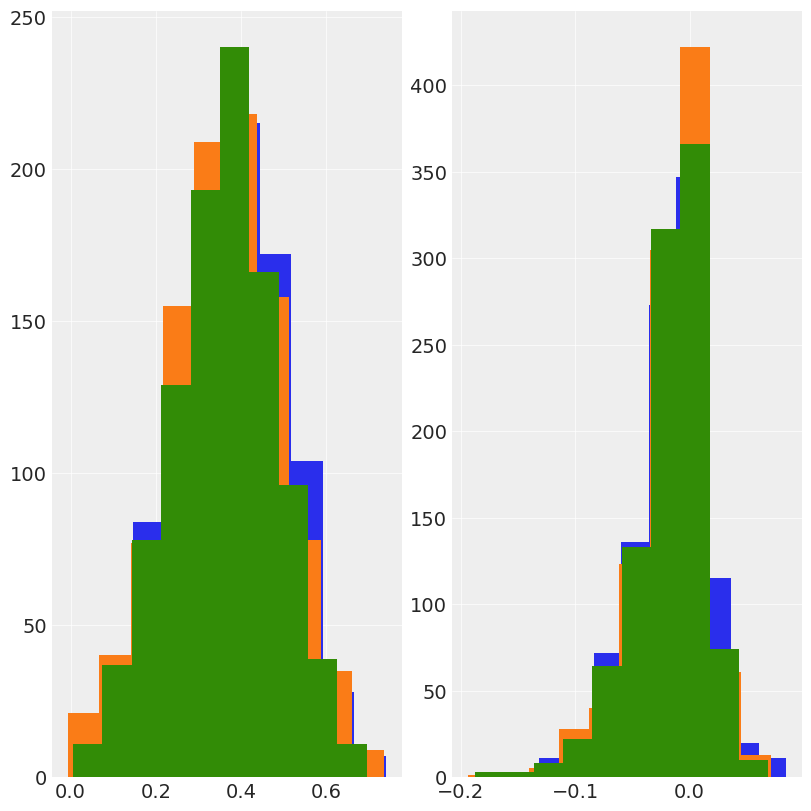

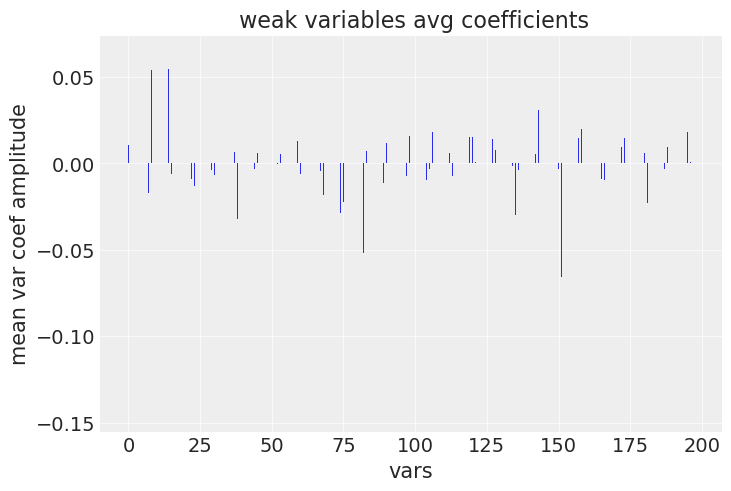

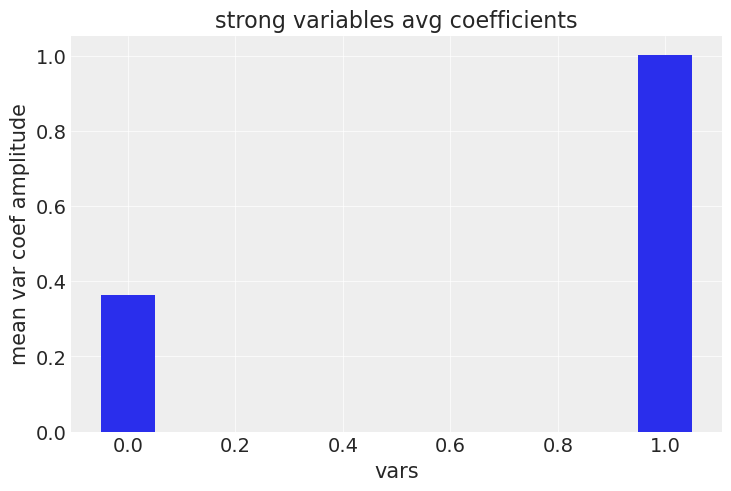

In [190]:
### idata.posterior.beta[0]
yp = 0
for i in range(nvars):
    yp += np.array(idata.posterior.beta[0][:,i])[:,None]*Xtest[:,i]

#ymu = np.mean(yp, axis = 0)
plt.figure(figsize = (15,4))
plt.subplot(121)
for ymu in yp:
    plt.plot(Ytest,ymu,'.', color = "red")

plt.plot([-5,5],[-5,5],'-', color = "blue")
plt.title(" Ypred vs Ytest Bayes")
ymu = 0
for i in range(nvars):
    ymu += np.array(idata.posterior.beta[0][:,i])[:,None]*X[:,i]
ymu = np.mean(ymu, axis = 0)

plt.subplot(122)

plt.plot(Ydata,ymu,'.')
plt.plot([-5,5],[-5,5],'-', color = "red")
plt.title("Avg Ypred vs Ysamples")


plt.figure(figsize = (12,6))
#plt.subplot(131)
plt.hist(np.array(idata.posterior.beta[:,:,0]).reshape(-1),bins = 40, density = True)
#plt.subplot(132)
fig = plt.hist(np.array(idata.posterior.beta[:,:,1]).reshape(-1),bins = 40, density = True)
#plt.subplot(133)
for i in range(2,40):
    plt.hist(np.array(idata.posterior.beta[:,:,i]).reshape(-1),bins = 40, density = True)

plt.vlines(2.1,0,20,color = "red", label = "true value")
plt.vlines(0.9,0,20,color = "red")
plt.legend()
plt.title("marginal posterior distribution Coefficients with uniform prior over b")
plt.figure(figsize = (15,8))
plt.subplot(141)
plt.plot(idata.posterior.beta[:,::100,0].T)
plt.subplot(142)

plt.plot(idata.posterior.beta[:,::100,1].T)
plt.subplot(143)

plt.plot(idata.posterior.beta[:,::100,3].T)
plt.subplot(144)

plt.plot(idata.posterior.beta[:,::100,4].T)


plt.figure(figsize = (15,8))
plt.subplot(141)
plt.hist(np.array(idata.posterior.beta[0,:,0].T).reshape(-1))
plt.hist(np.array(idata.posterior.beta[1,:,0].T).reshape(-1))
plt.hist(np.array(idata.posterior.beta[2,:,0].T).reshape(-1))

plt.subplot(142)
plt.hist(np.array(idata.posterior.beta[0,:,4].T).reshape(-1))
plt.hist(np.array(idata.posterior.beta[1,:,4].T).reshape(-1))
plt.hist(np.array(idata.posterior.beta[2,:,4].T).reshape(-1))


coefs_means = np.array(idata.posterior.beta).mean(axis = 0).mean(axis = 0)
plt.figure()
x = np.arange(0,198,1)
plt.bar(x,coefs_means[2:],width = 0.1)
plt.ylabel("mean var coef amplitude")
plt.xlabel("vars")
plt.title(" weak variables avg coefficients")


plt.figure()
x = np.arange(0,2,1)
plt.bar(x,coefs_means[:2],width = 0.1)
plt.ylabel("mean var coef amplitude")
plt.xlabel("vars")
plt.title("strong variables avg coefficients")

# Spark and slab, with Dirichlet

In [191]:
model = pm.Model()


conc = 4
beta = 1
alfa = 0.01
beta,alfa = beta*conc,alfa*conc
with model:

    beta,alfa = beta*conc,alfa*conc
    probs_inc = pm.Dirichlet("probs_inc",  a=[alfa,beta], shape = (nvars,2) )
    mu_mix = np.zeros((2,))
    sigma_mix = np.array([3,6e-2])
    components = pm.Normal.dist(mu=mu_mix, sigma=sigma_mix)
    
    beta = pm.Mixture('beta', w=probs_inc, comp_dists=components)
    
    ymu = pm.math.dot(X,beta)

    ysigma = pm.ChiSquared("chi",samples-1)
    ysigma =ysigma*(nvars*beta_sigma**2+sigma**2)/(samples-1)
    ysigma = pm.Deterministic("sigma",np.sqrt(ysigma))
    y = pm.Normal("Y",ymu,ysigma,observed = Ydata)
    idata = pm.sample(6000, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (12 chains in 12 jobs)
NUTS: [probs_inc, beta, chi]


Sampling 12 chains for 1_000 tune and 6_000 draw iterations (12_000 + 72_000 draws total) took 130 seconds.
There were 2153 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.386, but should be close to 0.8. Try to increase the number of tuning steps.


## Plot results

Text(0.5, 1.0, 'strong variables avg coefficients')

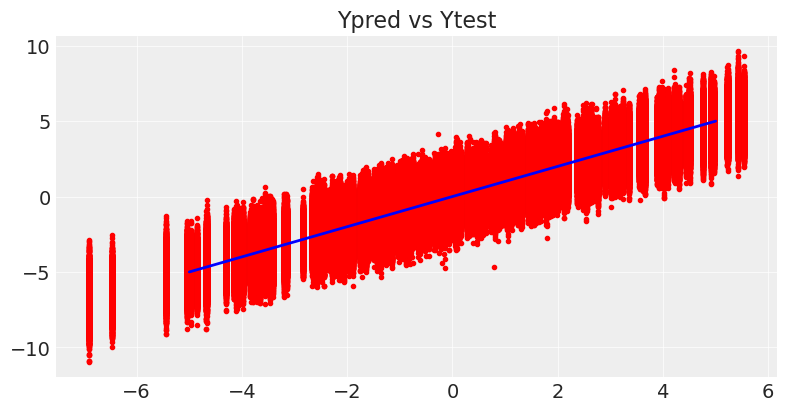

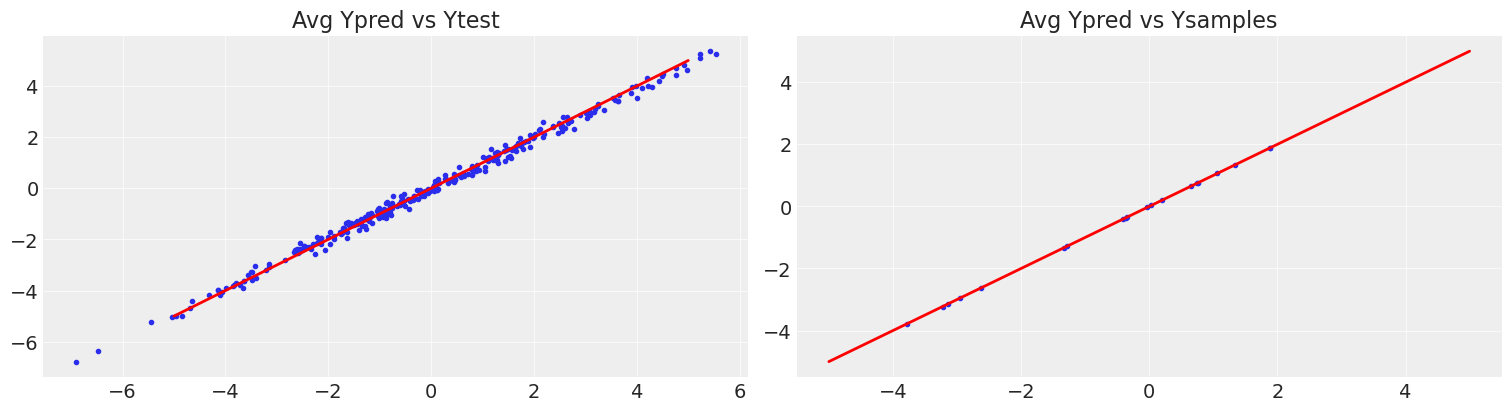

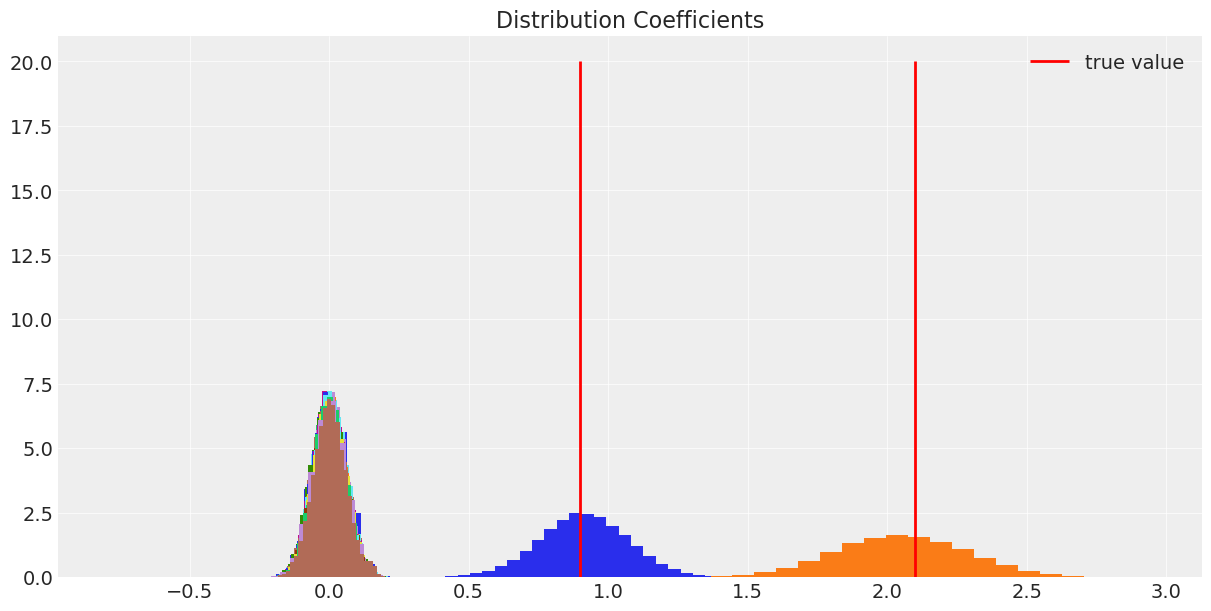

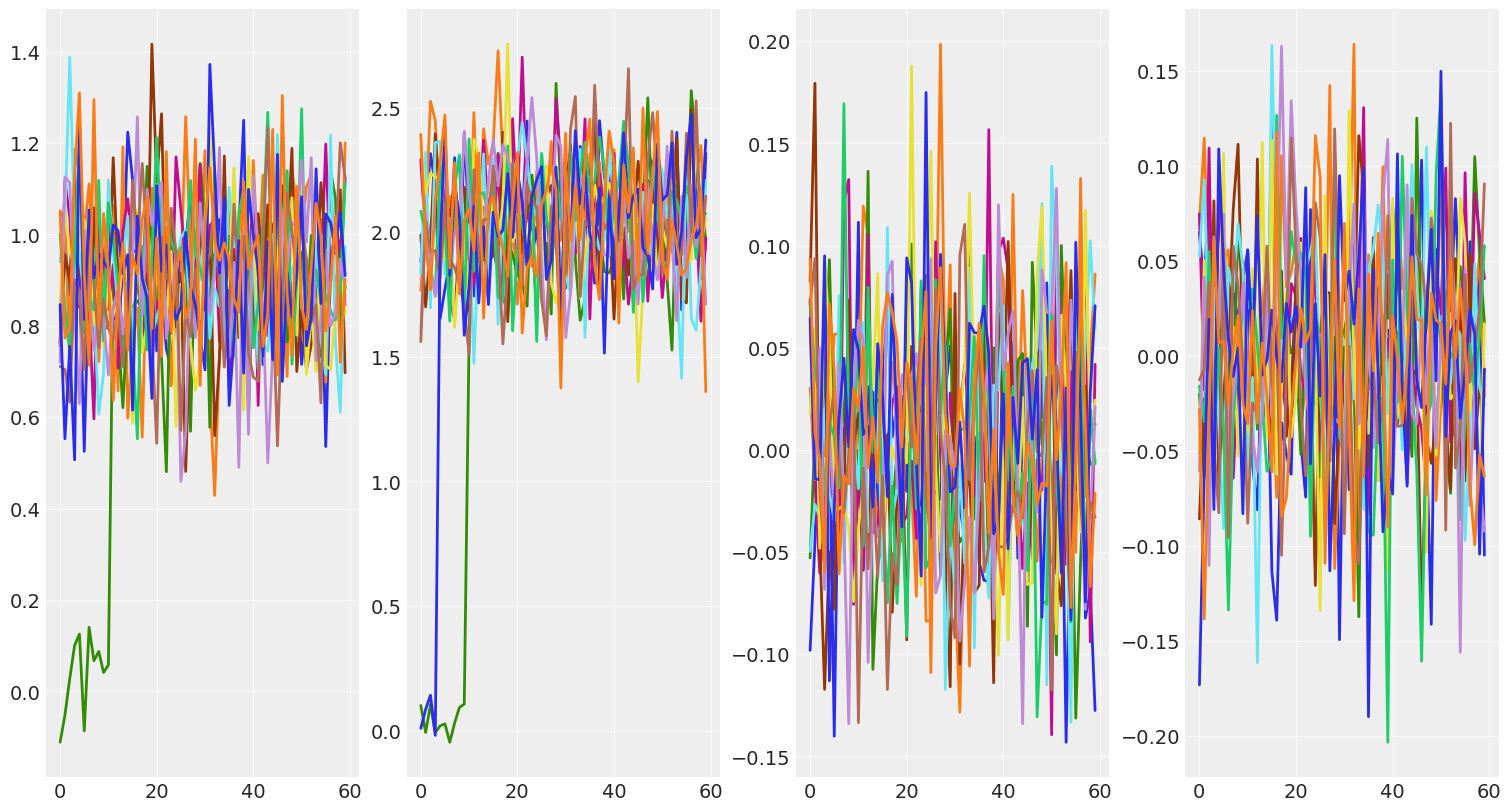

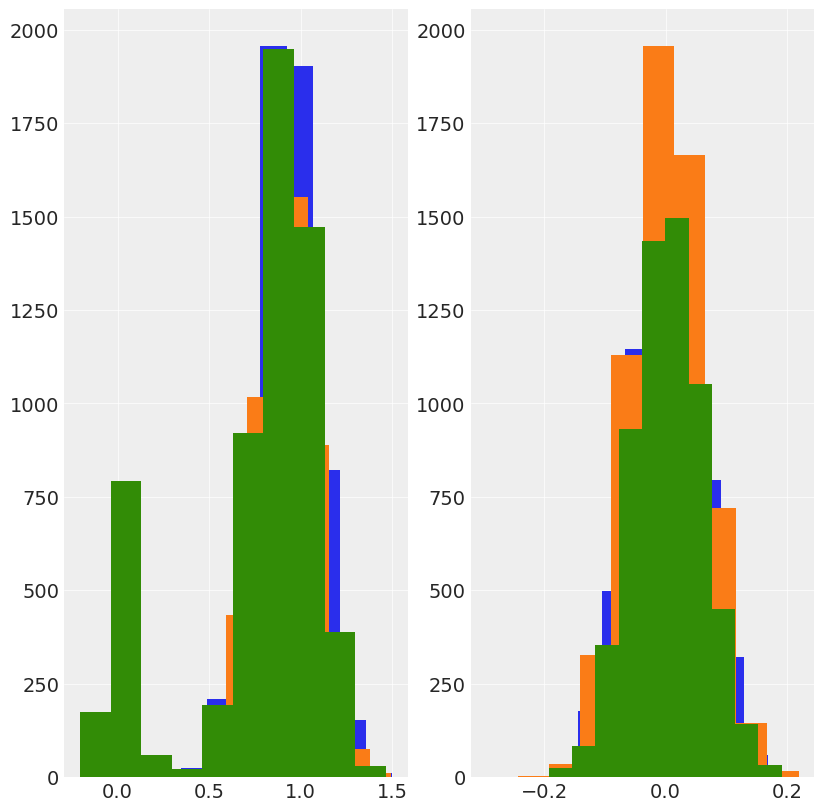

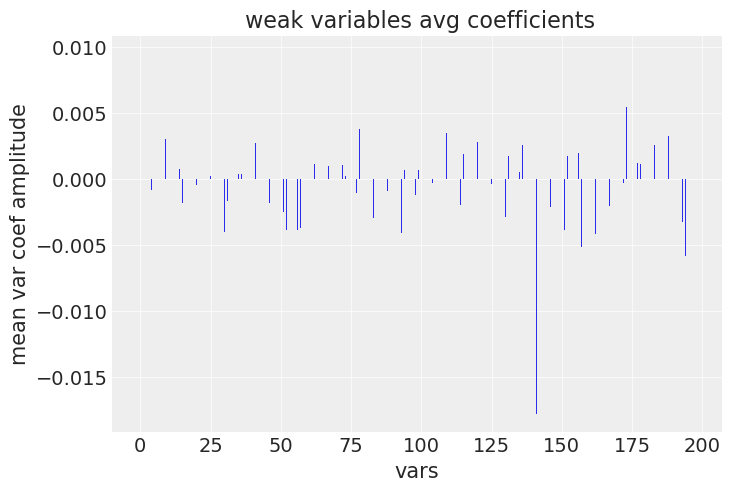

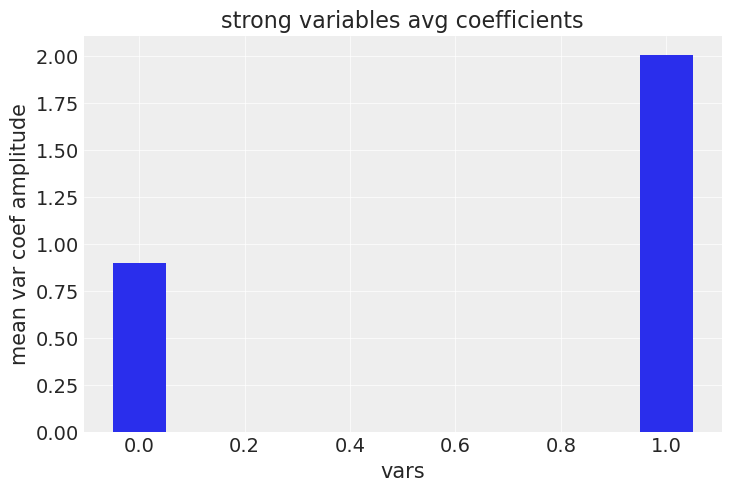

In [192]:
yp = 0
for i in range(nvars):
    yp += np.array(idata.posterior.beta[0][:,i])[:,None]*Xtest[:,i]

#ymu = np.mean(yp, axis = 0)
plt.figure(figsize = (15,4))
plt.subplot(121)
for ymu in yp:
    plt.plot(Ytest,ymu,'.', color = "red")
plt.plot([-5,5],[-5,5],'-', color = "blue")

plt.title("Ypred vs Ytest")


yp = 0
for i in range(nvars):
    yp += np.array(idata.posterior.beta[0][:,i])[:,None]*Xtest[:,i]

ymu = np.mean(yp, axis = 0)
plt.figure(figsize = (15,4))
plt.subplot(121)
plt.plot(Ytest,ymu,'.')
plt.plot([-5,5],[-5,5],'-', color = "red")
plt.title("Avg Ypred vs Ytest")
ymu = 0
for i in range(nvars):
    ymu += np.array(idata.posterior.beta[0][:,i])[:,None]*X[:,i]
ymu = np.mean(ymu, axis = 0)
plt.subplot(122)
plt.plot(Ydata,ymu,'.')
plt.plot([-5,5],[-5,5],'-', color = "red")
plt.title("Avg Ypred vs Ysamples")


plt.figure(figsize = (12,6))
#plt.subplot(131)
plt.hist(np.array(idata.posterior.beta[:,:,0]).reshape(-1),bins = 40, density = True)
#plt.subplot(132)
fig = plt.hist(np.array(idata.posterior.beta[:,:,1]).reshape(-1),bins = 40, density = True)
#plt.subplot(133)
for i in range(2,40):
    plt.hist(np.array(idata.posterior.beta[:,:,i]).reshape(-1),bins = 40, density = True)

plt.vlines(2.1,0,20,color = "red", label = "true value")
plt.vlines(0.9,0,20,color = "red")
plt.legend()
plt.title("Distribution Coefficients")
plt.figure(figsize = (15,8))
plt.subplot(141)
plt.plot(idata.posterior.beta[:,::100,0].T)
plt.subplot(142)

plt.plot(idata.posterior.beta[:,::100,1].T)
plt.subplot(143)

plt.plot(idata.posterior.beta[:,::100,3].T)
plt.subplot(144)

plt.plot(idata.posterior.beta[:,::100,4].T)


plt.figure(figsize = (15,8))
plt.subplot(141)
plt.hist(np.array(idata.posterior.beta[0,:,0].T).reshape(-1))
plt.hist(np.array(idata.posterior.beta[1,:,0].T).reshape(-1))
plt.hist(np.array(idata.posterior.beta[2,:,0].T).reshape(-1))

plt.subplot(142)
plt.hist(np.array(idata.posterior.beta[0,:,4].T).reshape(-1))
plt.hist(np.array(idata.posterior.beta[1,:,4].T).reshape(-1))
plt.hist(np.array(idata.posterior.beta[2,:,4].T).reshape(-1))


coefs_means = np.array(idata.posterior.beta).mean(axis = 0).mean(axis = 0)
plt.figure()
x = np.arange(0,198,1)
plt.bar(x,coefs_means[2:],width = 0.1)
plt.ylabel("mean var coef amplitude")
plt.xlabel("vars")
plt.title(" weak variables avg coefficients")


plt.figure()
x = np.arange(0,2,1)
plt.bar(x,coefs_means[:2],width = 0.1)
plt.ylabel("mean var coef amplitude")
plt.xlabel("vars")
plt.title("strong variables avg coefficients")

# Spark and Slab with bernoulli

In [193]:
sigma_thin = 6e-2
sigma_fat = 3
model = pm.Model()

with model:

    pinclusion = pm.Uniform("pinclusion",0.0,0.07)
    inclusion = pm.Bernoulli("bernoulli",pinclusion, shape = (nvars))

    beta = pm.Normal("beta",mu=0, sigma = (1-inclusion)*sigma_thin+inclusion*sigma_fat)
    
    
    ymu = pm.math.dot(X,beta)
    ysigma = pm.ChiSquared("chi",samples-1)
    ysigma =ysigma*(nvars*beta_sigma**2+sigma**2)/(samples-1)
    ysigma = pm.Deterministic("sigma",np.sqrt(ysigma))
    y = pm.Normal("Y",ymu,ysigma,observed = Ydata)
    idata = pm.sample(3000, tune = 1000,target_accept = 0.8)

## Plot results

Text(0.5, 1.0, 'strong variables avg coefficients')

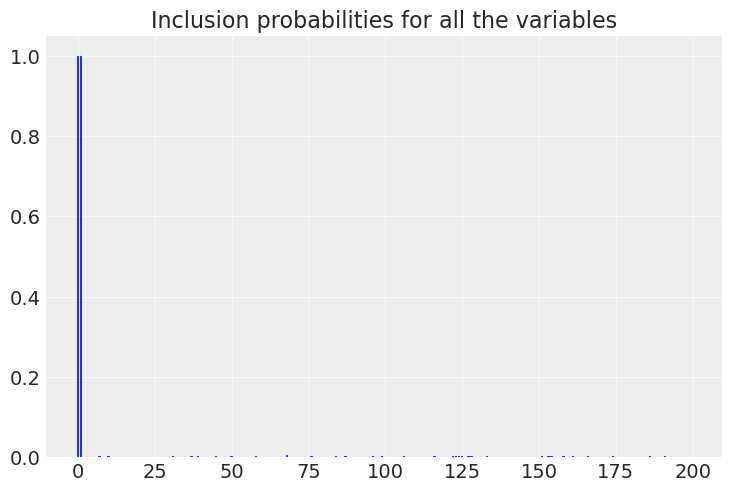

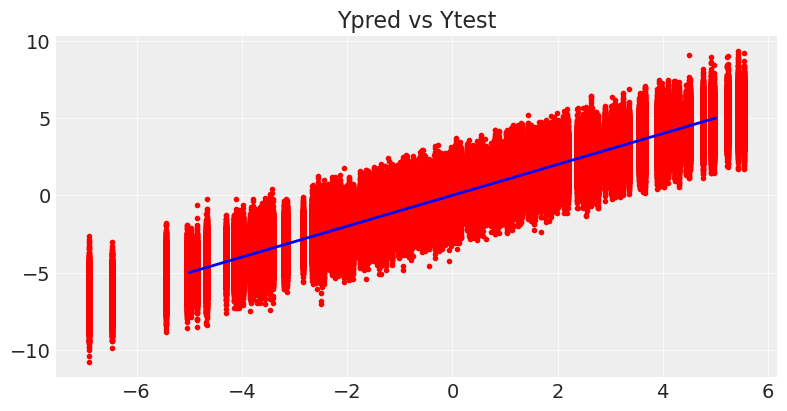

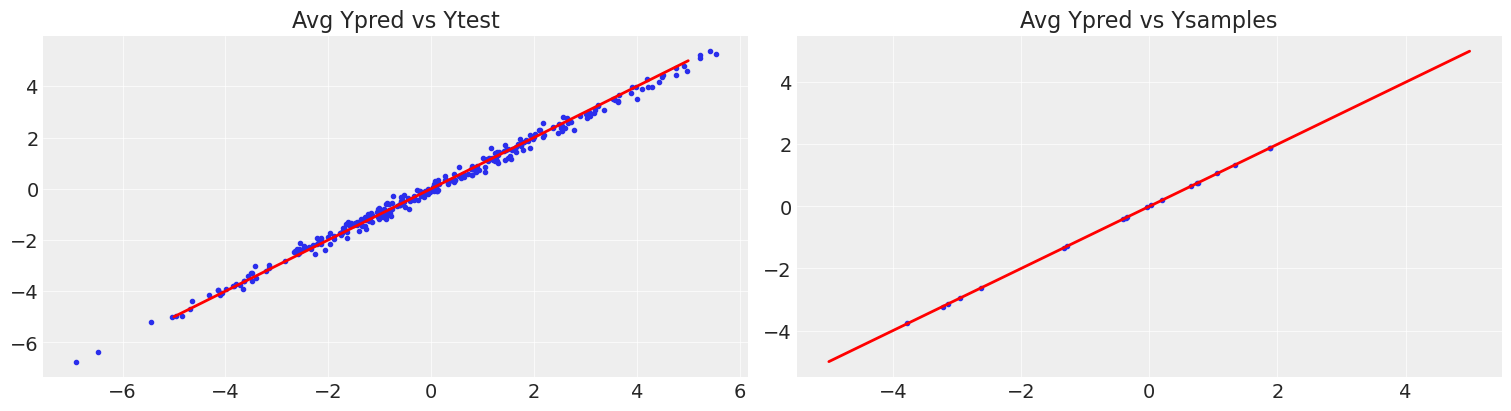

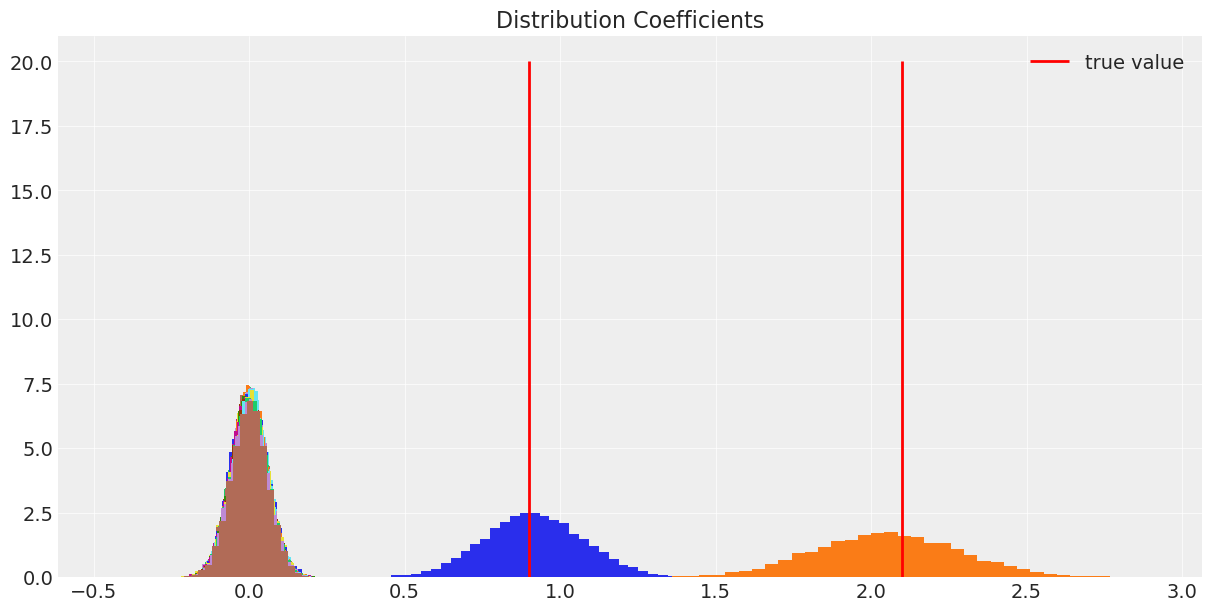

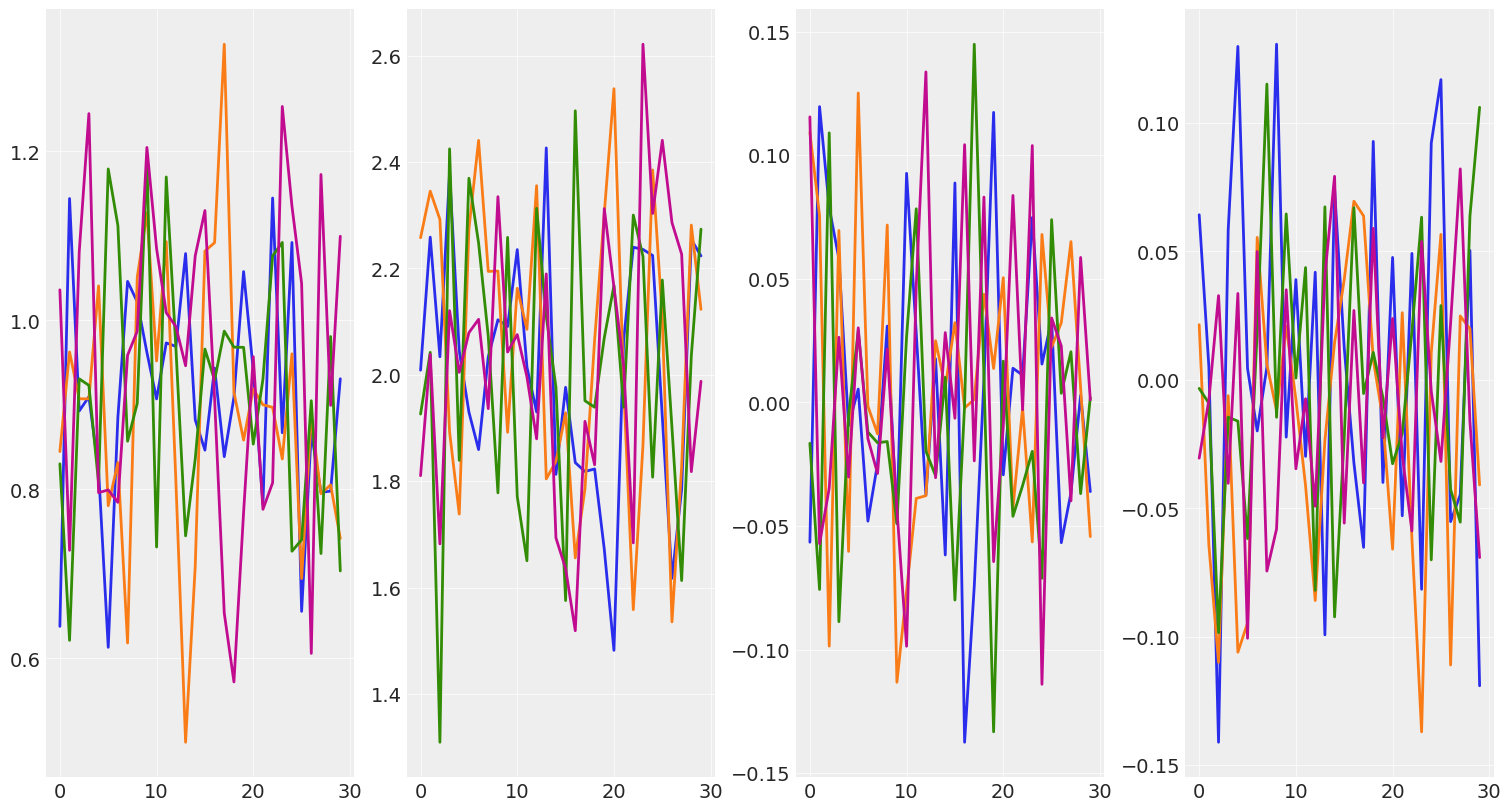

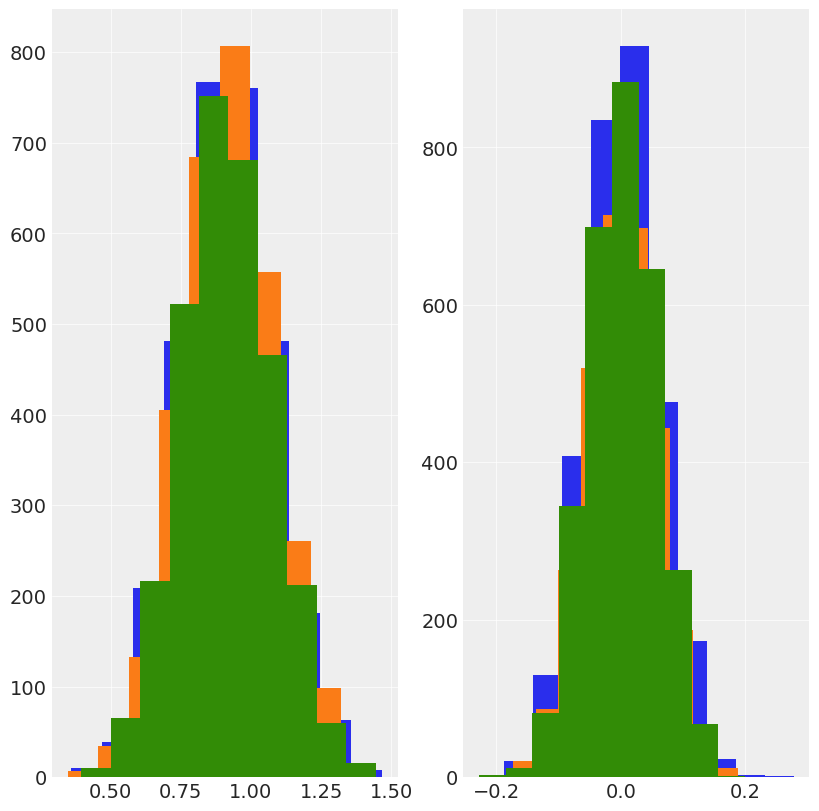

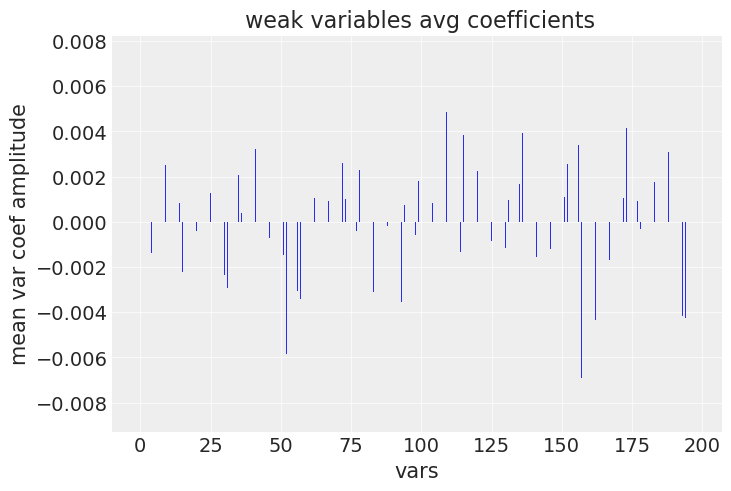

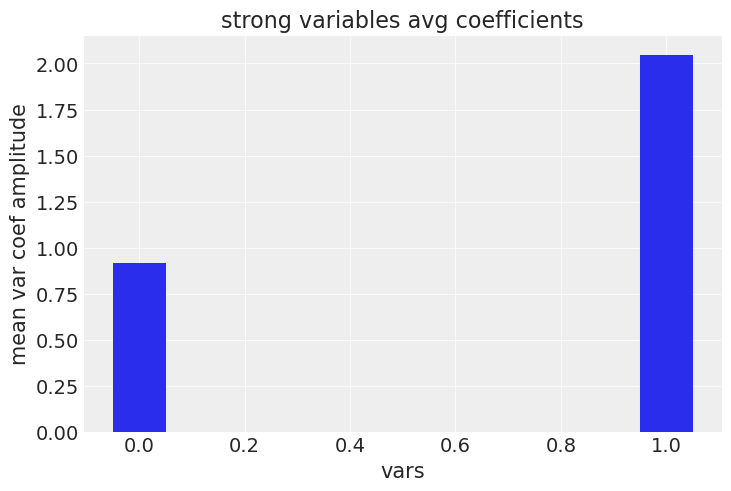

In [198]:
probs = np.array(idata.posterior.bernoulli).mean(axis = 0).mean(axis = 0)
plt.bar(np.arange(0,200,1),probs)
plt.title("Inclusion probabilities for all the variables")

yp = 0
for i in range(nvars):
    yp += np.array(idata.posterior.beta[0][:,i])[:,None]*Xtest[:,i]

#ymu = np.mean(yp, axis = 0)
plt.figure(figsize = (15,4))
plt.subplot(121)
for ymu in yp:
    plt.plot(Ytest,ymu,'.', color = "red")
plt.plot([-5,5],[-5,5],'-', color = "blue")

plt.title("Ypred vs Ytest")


yp = 0
for i in range(nvars):
    yp += np.array(idata.posterior.beta[0][:,i])[:,None]*Xtest[:,i]

ymu = np.mean(yp, axis = 0)
plt.figure(figsize = (15,4))
plt.subplot(121)
plt.plot(Ytest,ymu,'.')
plt.plot([-5,5],[-5,5],'-', color = "red")
plt.title("Avg Ypred vs Ytest")
ymu = 0
for i in range(nvars):
    ymu += np.array(idata.posterior.beta[0][:,i])[:,None]*X[:,i]
ymu = np.mean(ymu, axis = 0)
plt.subplot(122)
plt.plot(Ydata,ymu,'.')
plt.plot([-5,5],[-5,5],'-', color = "red")
plt.title("Avg Ypred vs Ysamples")


plt.figure(figsize = (12,6))
#plt.subplot(131)
plt.hist(np.array(idata.posterior.beta[:,:,0]).reshape(-1),bins = 40, density = True)
#plt.subplot(132)
fig = plt.hist(np.array(idata.posterior.beta[:,:,1]).reshape(-1),bins = 40, density = True)
#plt.subplot(133)
for i in range(2,40):
    plt.hist(np.array(idata.posterior.beta[:,:,i]).reshape(-1),bins = 40, density = True)

plt.vlines(2.1,0,20,color = "red", label = "true value")
plt.vlines(0.9,0,20,color = "red")
plt.legend()
plt.title("Distribution Coefficients")
plt.figure(figsize = (15,8))
plt.subplot(141)
plt.plot(idata.posterior.beta[:,::100,0].T)
plt.subplot(142)

plt.plot(idata.posterior.beta[:,::100,1].T)
plt.subplot(143)

plt.plot(idata.posterior.beta[:,::100,3].T)
plt.subplot(144)

plt.plot(idata.posterior.beta[:,::100,4].T)


plt.figure(figsize = (15,8))
plt.subplot(141)
plt.hist(np.array(idata.posterior.beta[0,:,0].T).reshape(-1))
plt.hist(np.array(idata.posterior.beta[1,:,0].T).reshape(-1))
plt.hist(np.array(idata.posterior.beta[2,:,0].T).reshape(-1))

plt.subplot(142)
plt.hist(np.array(idata.posterior.beta[0,:,4].T).reshape(-1))
plt.hist(np.array(idata.posterior.beta[1,:,4].T).reshape(-1))
plt.hist(np.array(idata.posterior.beta[2,:,4].T).reshape(-1))


coefs_means = np.array(idata.posterior.beta).mean(axis = 0).mean(axis = 0)
plt.figure()
x = np.arange(0,198,1)
plt.bar(x,coefs_means[2:],width = 0.1)
plt.ylabel("mean var coef amplitude")
plt.xlabel("vars")
plt.title(" weak variables avg coefficients")


plt.figure()
x = np.arange(0,2,1)
plt.bar(x,coefs_means[:2],width = 0.1)
plt.ylabel("mean var coef amplitude")
plt.xlabel("vars")
plt.title("strong variables avg coefficients")

# Horshoe/reg horseshoe

In [214]:
model = pm.Model()
τo = 0.01
with model:
    λm = pm.HalfCauchy("lambda",  beta = 1, shape = (nvars))
  #  λ = pm.HalfNormal("lambda",  sigma = 1, shape = (nvars))
    τ = pm.HalfNormal("tau", sigma = τo, shape = (nvars))

   # c2 = pm.InverseGamma("c",1,1)
   # λm = pm.Deterministic("lambdareg",λ*pm.math.sqrt(c2)/pm.math.sqrt(c2+τ**2*λ**2))
    σ = pm.Deterministic('horseshoe', τ*τ*λm*λm)
    beta = pm.Normal('beta',0,σ, shape = (nvars))
    
    
    ymu = pm.math.dot(X,beta)
    ysigma = pm.ChiSquared("chi",samples-1)
    ysigma =ysigma*(nvars*beta_sigma**2+sigma**2)/(samples-1)
    ysigma = pm.Deterministic("sigma",np.sqrt(ysigma))
    y = pm.Normal("Y",ymu,ysigma,observed = Ydata)
    idata = pm.sample(3000, tune = 500, cores = 12)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (12 chains in 12 jobs)
NUTS: [lambda, tau, beta, chi]


KeyboardInterrupt: 

Text(0.5, 1.0, 'strong variables avg coefficients')

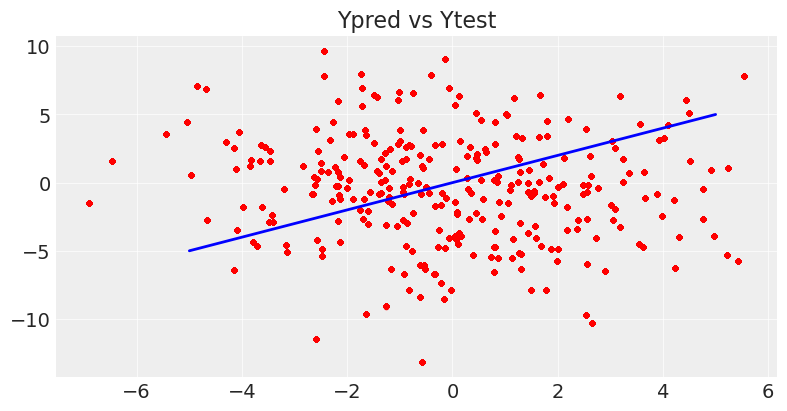

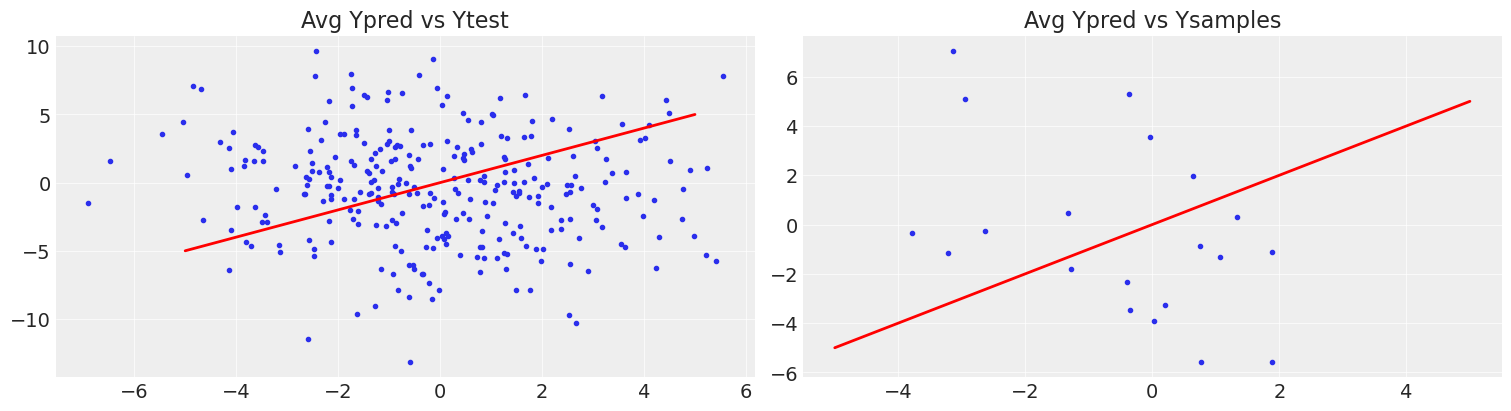

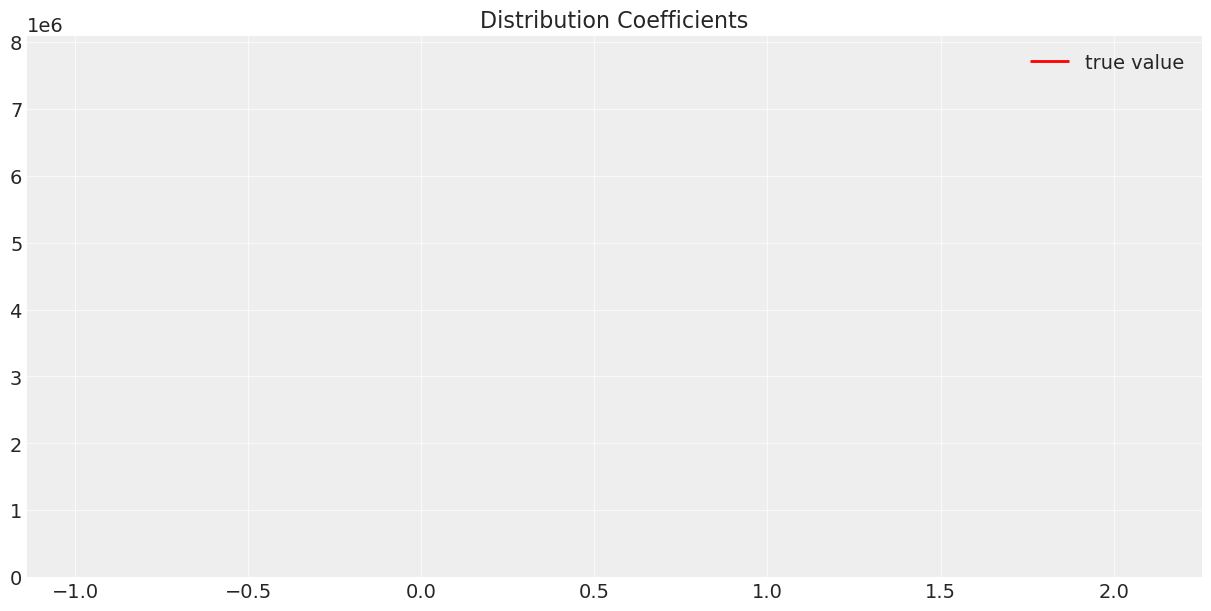

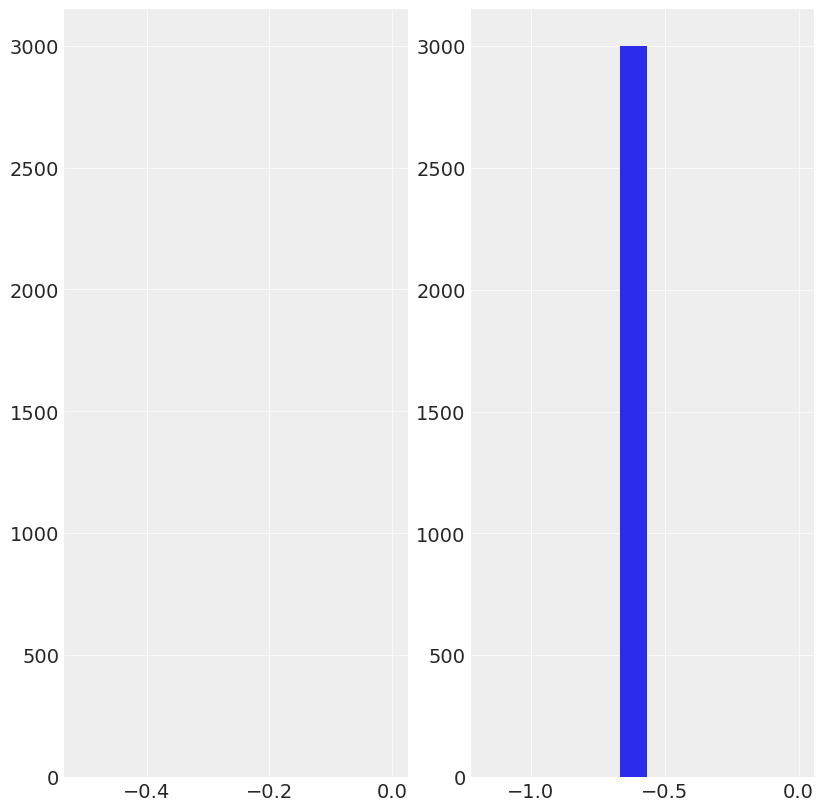

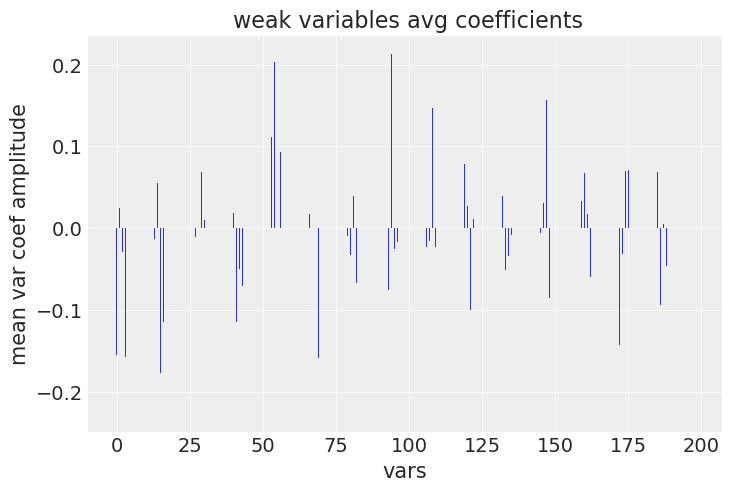

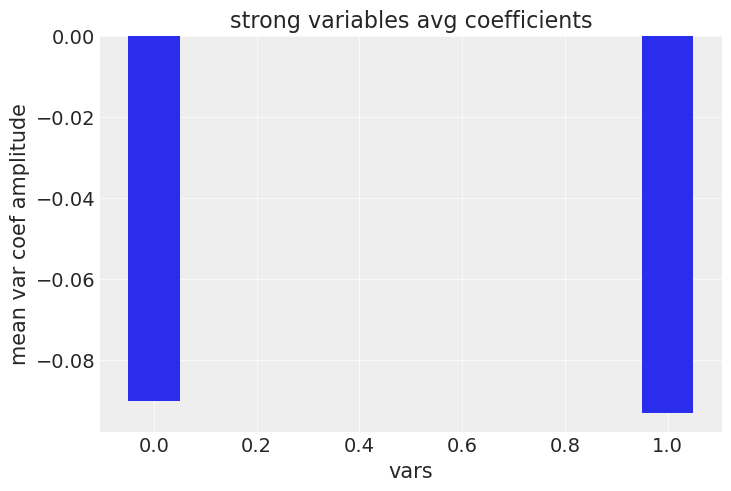

In [212]:

yp = 0
for i in range(nvars):
    yp += np.array(idata.posterior.beta[0][:,i])[:,None]*Xtest[:,i]

#ymu = np.mean(yp, axis = 0)
plt.figure(figsize = (15,4))
plt.subplot(121)
for ymu in yp:
    plt.plot(Ytest,ymu,'.', color = "red")
plt.plot([-5,5],[-5,5],'-', color = "blue")

plt.title("Ypred vs Ytest")


yp = 0
for i in range(nvars):
    yp += np.array(idata.posterior.beta[0][:,i])[:,None]*Xtest[:,i]

ymu = np.mean(yp, axis = 0)
plt.figure(figsize = (15,4))
plt.subplot(121)
plt.plot(Ytest,ymu,'.')
plt.plot([-5,5],[-5,5],'-', color = "red")
plt.title("Avg Ypred vs Ytest")
ymu = 0
for i in range(nvars):
    ymu += np.array(idata.posterior.beta[0][:,i])[:,None]*X[:,i]
ymu = np.mean(ymu, axis = 0)
plt.subplot(122)
plt.plot(Ydata,ymu,'.')
plt.plot([-5,5],[-5,5],'-', color = "red")
plt.title("Avg Ypred vs Ysamples")


plt.figure(figsize = (12,6))
#plt.subplot(131)
plt.hist(np.array(idata.posterior.beta[:,:,0]).reshape(-1),bins = 40, density = True)
#plt.subplot(132)
fig = plt.hist(np.array(idata.posterior.beta[:,:,1]).reshape(-1),bins = 40, density = True)
#plt.subplot(133)
for i in range(2,40):
    plt.hist(np.array(idata.posterior.beta[:,:,i]).reshape(-1),bins = 40, density = True)

plt.vlines(2.1,0,20,color = "red", label = "true value")
plt.vlines(0.9,0,20,color = "red")
plt.legend()
plt.title("Distribution Coefficients")


plt.figure(figsize = (15,8))
plt.subplot(141)
plt.hist(np.array(idata.posterior.beta[0,:,0].T).reshape(-1))
plt.hist(np.array(idata.posterior.beta[1,:,0].T).reshape(-1))
plt.hist(np.array(idata.posterior.beta[2,:,0].T).reshape(-1))

plt.subplot(142)
plt.hist(np.array(idata.posterior.beta[0,:,4].T).reshape(-1))
plt.hist(np.array(idata.posterior.beta[1,:,4].T).reshape(-1))
plt.hist(np.array(idata.posterior.beta[2,:,4].T).reshape(-1))


coefs_means = np.array(idata.posterior.beta).mean(axis = 0).mean(axis = 0)
plt.figure()
x = np.arange(0,198,1)
plt.bar(x,coefs_means[2:],width = 0.1)
plt.ylabel("mean var coef amplitude")
plt.xlabel("vars")
plt.title(" weak variables avg coefficients")


plt.figure()
x = np.arange(0,2,1)
plt.bar(x,coefs_means[:2],width = 0.1)
plt.ylabel("mean var coef amplitude")
plt.xlabel("vars")
plt.title("strong variables avg coefficients")